# 1. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

In [2]:
import cellpose
from cellpose import models

In [3]:
from tqdm import tqdm

# 2. Define data parameters

In [4]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 3

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict = {"dna":1,"Mdc1":2,"other":3}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
mdc1_key =  "Mdc1"
dna_key = 'dna'  # temporary fix since DNA is not good
other_key="other"

# Whether to analyze the sub-area masks defined by the second marker within the first marker (e.g., h2ax within the mdc) 
analyze_ch_for_2nd_marker_dict = {1:True,2:True,3:False}

# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"

# define well here
# candidate wells: 3, 4, 5, 6, 7
#well_name = 'well3' # done
#well_name = 'well4' #done
#well_name = 'well5' #done
#well_name = 'well6' #done
#well_name = 'well7' #done


############################# CHANGE WELL FOR DATA OF INTEREST ABVOE!##########################################

############################# CHANGE WELL FOR DATA OF INTEREST BELOW!##########################################
data_output_folder = r"D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\230117IF_230114exp_p53ko_noco\210114_40x_45h"
data_main_folder =os.path.join(data_output_folder, '*')
############################# CHANGE WELL FOR DATA OF INTEREST HERE!##########################################



data_input_folder = data_main_folder
data_files = [file for file in glob.glob(data_input_folder) if file[-3:]=="nd2"]

data_files

['D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\230117IF_230114exp_p53ko_noco\\210114_40x_45h\\230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 noco_.nd2']

In [5]:
# analyze all ND file or not
# also used as bool setting for adjusting code indendation between different pipelines
_analyze_all_nd = True
#_analyze_all_nd = True

# print progress
_verbose = True

# bad fovs to exclude (e.g., out of focus nd file) if analyze all nd file
# {nd_file_index : [fov_indexes]}
if _analyze_all_nd:
    #fov_to_exclude_dict = {1:[4,5],5:[2,3]}
    fov_to_exclude_dict = {1:[16]}
    

# The pixel size for excluding small 53BP_body;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 body foci exclusion durng analysis
# Desired foci exclusion can still be performed post-hoc in the resulting dataframe after analysis
# use 200 for 40x images
small_53BP_size = 200

# Other parameteres for image analysis
# border pixel removal for h2ax (or other markers within sub-mdc1 area) positive or less-positive area
h2ax_border_size_filter = 1

# aproximate size for each cell (nuclei)
nuclei_filter = 1000

# for removing tiny nucleoli areas
small_nucleoli_dirt = 10

# erosion factor for dna segmenation
erosion_factor_dna = 5


# std ratio for positive mdc or h2ax, etc calling
h2ax_std_ratio = 3
mdc_std_ratio = 2

# if analyze cell of interest based on annotation:
# the approx distance radius range between the given center and the segmenated center
coord_dist = 100
# if if perform image cropping covering the cell of interest or not
crop_image =  True
raw_image_size = [2048,2048]

# if adjust the focal plane using a smaller crop range than the range used for actual analysis (aka cell size)
narrow_adjust = True
# define the narrowed ratio of the initial crop
narrow_ratio = 0.1


# if re-adjust the focal plane based on cell of interest
adjust_z_for_cell = False


# the cropped image size if performing image cropping covering the cell of interest
cell_size =400

# the percentile for Pol2 to segment the nucleoli area
po2_neg_percentile = 10

# use DAPI channel to do nuclei segmentation or not
use_dna_nuclei = True # shall be good since local dapi in the center is okay

# the alternative channel key if using other channel for nuclei segmentation
if not use_dna_nuclei:
    dna_key = pol2_key
    
    
# specify the region from the whole fov where analysis would be performed
search_xylim = [0,2048]  # Note that DNA channel from the data often is not evenly illuminated


# if save the cropped raw images or not
save_crop_raw_image = True



# 3. Analyze data

In [6]:
# Initiate result dataframe to store analysis measurement:
measurement_for_all_fov_df = pd.DataFrame()


# Initiate cellpose model
model= models.Cellpose(gpu=False, model_type='nuclei',)
####################################################################################
# Loop through each ND data file
for data_ind, data in enumerate(data_files[:]):

    # data name: usually the experiment name 
    data_name = data.split('\\')[-1]

    # if use annotation, then check if data/exp name is in the annotation dict
    if not _analyze_all_nd:
        if data_name in cell_info_dict.keys():
            if _verbose:
                print(f"-----------------------------------------------------------")    
                print(f"-- Start analyzing the dataset of {data_name}")
            # load data if ND data exists in the anntation
            images = ND2Reader(data)
            num_of_planes = images.sizes["z"] # load 'z' info
            # multi-fov image
            if 'v' in images.sizes.keys():
                num_of_fov = images.sizes["v"] # load 'v' info
            # set num_of_fov as 1 for single fov image
            else:
                num_of_fov = 1
        
            # load fov_of_interest from the preprocessed cell_info_dict
            fov_of_interest_str = cell_info_dict[data_name].keys()
            fov_of_interest = [(int(_fov_str)-1) for _fov_str in fov_of_interest_str]
            #print(fov_of_interest)
        else:
            fov_of_interest = []
                    
    # load data without using annotation
    else:
        images = ND2Reader(data)
        num_of_planes = images.sizes["z"] # load 'z' info
        # multi-fov image
        if 'v' in images.sizes.keys():
            num_of_fov = images.sizes["v"] # load 'v' info
        # set num_of_fov as 1 for single fov image
        else:
            num_of_fov = 1
            
        # if exclude bad focal plane that are not focused
        fovs_all = list(range(num_of_fov))
        if data_ind in fov_to_exclude_dict.keys():
            fov_of_interest = [ind for ind in fovs_all if ind not in fov_to_exclude_dict[data_ind]]
        else:
            fov_of_interest = fovs_all
            
###########################################################################################
# Loop through each FOV of interest
    if _verbose:# for indentation purposes
        
        for _fov_id in tqdm(fov_of_interest[:]):                
            
            # use annotation dict to look for cell of interest
            if not _analyze_all_nd:
                if _verbose:
                    print ('-- Use given annotation dict to find cells.')
                cell_coord_list = cell_info_dict[data_name][str(_fov_id+1)] 
            
            # use 3D nuclei signal to do segmenation by cellpose
            else:
                if _verbose:
                    print ('-- Generate 3D nuclei segmentation to find cells.')
                image_cell_3d = []
                for _lyr in range(num_of_planes): # ch index starts from 0
                    image_cell = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[dna_key]-1, z=_lyr))
                    image_cell_3d.append(image_cell)
                image_cell_3d = np.array(image_cell_3d)
                #
                nuclei_mask_3d,flows, styles, diams = model.eval(image_cell_3d, diameter=90, 
                                                    channels = [0,0],
                                                   flow_threshold=1, do_3D=False)
                
                noncell_mask_all = nuclei_mask_3d==0
                
                # remove edge cell
                nuclei_mask_3d=cellpose.utils.remove_edge_masks(nuclei_mask_3d, change_index=True)
                nuclei_mask_3d=cellpose.utils.fill_holes_and_remove_small_masks(nuclei_mask_3d, min_size=nuclei_filter)
                
                mask_save_path = data_output_folder + os.sep + f'segmentations_{mdc_std_ratio}_{small_53BP_size}_crop_subset_controlled' +  os.sep + \
                        f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                if not os.path.exists(mask_save_path):
                    os.makedirs(mask_save_path)
                mask_name = f'Nuclei_segmenations_exclude_edges_Pos_{_fov_id+1}.tif'
                if os.path.exists(mask_save_path+os.sep+mask_name):
                    os.remove(mask_save_path+os.sep+mask_name)
                io.imsave(mask_save_path+os.sep+mask_name,(skimage.img_as_ubyte(nuclei_mask_3d)), check_contrast=False)
                
                #print(num_of_nuclei)
                # if use the cell coord refined analysis
                cell_coord_list  = []
                for i in np.unique(nuclei_mask_3d)[:]:
                    if i >0:
                        # initate dict to store result
                        measurement_each_dict = {}
                        _cell_id=i
                        cand_nucleus = nuclei_mask_3d == i
                        cand_nucleus[cand_nucleus>0]=1
                        cand_nucleus = np.array(cand_nucleus)
                        # append the coord for the objects of interest
                        region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                        # centroid coord as YX, select the cells within the predefined bound
                        check_Y_pos = region.centroid[0] >= search_xylim[0] and region.centroid[0] <= search_xylim[1]
                        check_X_pos = region.centroid[1] >= search_xylim[0] and region.centroid[1] <= search_xylim[1]
                        if check_Y_pos and check_X_pos:
                            cell_center = [int(region.centroid[1]),int(region.centroid[0])]
                            cell_coord_list.append(cell_center)
                            if _verbose:
                                print (f'-- Processing Cell#{_cell_id} from the image')

                            # define as nuclei mask
                            nuclei_to_measure = cand_nucleus
                            noncell_background = noncell_mask_all

                            # Find the best focal plane using the m6T/mdc (the factor key) channel for the cell of interest  
                            #image_fl = []
                            image_std = []
                            image_3d_for_label = []

                            for _lyr in range(num_of_planes): # ch index starts from 0
                                image_array_fl = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=_lyr))                  
                                # do cropping if necessary; remember to inver XY
                                if crop_image: # current crop size as rough cell size
                                    crop_y1 = int(max(0,cell_center[1]-cell_size/2))
                                    crop_y2 = int(min(raw_image_size[1],cell_center[1]+cell_size/2))
                                    crop_x1 = int(max(0,cell_center[0]-cell_size/2))
                                    crop_x2 = int(min(raw_image_size[0],cell_center[0]+cell_size/2))
                                    image_array_fl = image_array_fl[crop_y1:crop_y2,crop_x1:crop_x2]


                                 # use image signal STD distribution to find the best focal plane for the plane of interest
                                _fl=image_array_fl.flatten()
                                image_std.append(np.std(_fl))
                                #also append the image for later potential usage (eg. re-adjust focal plane)
                                #image_3d_for_label.append(image_array_fl)

                            # find the initial best focal plane using std features          
                            best_plane_index = np.argmax(np.array(image_std))
                            if _verbose:
                                print(f"-- Analyzing the plane {best_plane_index+1} in fov {_fov_id+1}.")
                            sel_img = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=best_plane_index))                  

                            if crop_image: # current crop size as rough cell size
                                sel_img = sel_img[crop_y1:crop_y2,crop_x1:crop_x2]
                                nuclei_to_measure = nuclei_to_measure[crop_y1:crop_y2,crop_x1:crop_x2]
                                noncell_background = noncell_background[crop_y1:crop_y2,crop_x1:crop_x2]


                            # Get cellular mdc mask 
                            mdc_intensity = sel_img*nuclei_to_measure
                            mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
                            mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*mdc_std_ratio
                            mdc_mask = np.logical_and(sel_img>mdc_positive_th, nuclei_to_measure)
                            mdc_chr_mask = remove_small_objects(mdc_mask, small_53BP_size,connectivity=1)
                            mdc_chr_mask = ndi.binary_fill_holes(mdc_chr_mask)
                            mdc_chr_mask = dilation(mdc_chr_mask,disk(1))
                            mdc_chr_mask = erosion(mdc_chr_mask,disk(1))

                            # Append info and results for cells of interest
                            measurement_each_dict['exp_name']=data_input_folder.split('\\')[-2]
                            measurement_each_dict['position_id']=f'{data_name}_Pos{_fov_id+1}'
                            measurement_each_dict['cell_id']=int(_cell_id+1)
                            measurement_each_dict['cell_xyz_coord']=[cell_center, best_plane_index+1]

                            measurement_each_dict['mdc1_size']=np.sum(mdc_chr_mask)
                            measurement_each_dict['nucleus_size']=np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_relative_size']=np.sum(mdc_chr_mask)/np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_mdc1_intensity']=np.mean((sel_img * mdc_chr_mask)[mdc_chr_mask!=0])
                            measurement_each_dict['nucleus_mdc1_intensity']=np.mean((sel_img * nuclei_to_measure)[nuclei_to_measure!=0])
                            measurement_each_dict['noncell_mdc1_intensity']=np.mean((sel_img * noncell_background)[noncell_background!=0])
                            measurement_each_dict['mdc1_mdc1_norm_intensity']=((measurement_each_dict['mdc1_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity'])
                                                                               /(measurement_each_dict['nucleus_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity']))


                            measurement_for_each_cell_df=pd.DataFrame.from_dict(measurement_each_dict,orient='index').transpose()
                            measurement_for_all_fov_df = pd.concat([measurement_for_all_fov_df,measurement_for_each_cell_df])

                            # Save individual valid mask or image for each cell 
                            mask_file_list = [mdc_chr_mask,nuclei_to_measure,sel_img]
                            mask_savename_list = [f'cell_{_cell_id+1}_cand_MN_body.tif',
                                                  f'cell_{_cell_id+1}_nucleus.tif',
                                                  f'cell_{_cell_id+1}_MDC1_image.tif',]

                            for _name, _file in zip(mask_savename_list,mask_file_list):
                                # remove old ones if exist
                                if os.path.exists(mask_save_path+os.sep+_name):
                                    os.remove(mask_save_path+os.sep+_name)
                                if _name == f'cell_{_cell_id+1}_MDC1_image.tif':
                                    if save_crop_raw_image:
                                        io.imsave(mask_save_path+os.sep+_name,_file, check_contrast=False)
                                    else:
                                        pass
                                else:
                                    io.imsave(mask_save_path+os.sep+_name,(skimage.img_as_ubyte(_file)), check_contrast=False)



                                
# Save excel result
_save_results = True

if _save_results:
    analysis_savename = f'measurement_for_all_fov_background_subtracted_{mdc_std_ratio}_{small_53BP_size}_crop.xlsx'
    #analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
    analysis_save_path = data_output_folder + os.sep + 'analysis_subset_controlled' 
    if not os.path.exists(analysis_save_path):
        os.makedirs(analysis_save_path)
    measurement_for_all_fov_df.to_excel(analysis_save_path+os.sep+analysis_savename)
                            
                        

  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 16 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#2 from the image


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-- Analyzing the plane 4 in fov 1.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 1.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 1.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 1.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 1.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 1.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 1.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 1.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 1.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 1.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 1.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 1.
-- Processing Cell#14 from the image
-- Analyzing the plane 5 in fov 1.
-- Processing Cell#15 from the image
-- Analyzing the plane 6 in fov 1.
-- Processing Cell#16 from the image

  1%|▊                                                                                 | 1/101 [00:24<40:28, 24.28s/it]

-- Analyzing the plane 6 in fov 1.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 19 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 2.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 2.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 2.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 2.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 2.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 2.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 2.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 2.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 2.
-- Processing Cell#14 from the image
-- Analyzing the plane 5 in fov 2.
-

  2%|█▌                                                                                | 2/101 [00:53<44:42, 27.09s/it]

-- Analyzing the plane 6 in fov 2.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 21 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 3.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 3.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 3.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 3.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 3.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 3.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 3.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 3.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 3.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 3.
-- Processing Cell#14 from the image
-- Analyzing the plane 5 in fov 3.
-

  3%|██▍                                                                               | 3/101 [01:27<49:24, 30.25s/it]

-- Analyzing the plane 6 in fov 3.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 4.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 4.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 4.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 4.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 4.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 4.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 4.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#13 from the image
-- Analyzing the plane 

  4%|███▏                                                                              | 4/101 [01:56<48:28, 29.99s/it]

-- Analyzing the plane 7 in fov 4.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 11 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 5.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 5.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 5.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 5.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 5.
-- Processing Cell#11 from the image


  5%|████                                                                              | 5/101 [02:22<45:35, 28.50s/it]

-- Analyzing the plane 7 in fov 5.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 4 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 6.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 6.
-- Processing Cell#4 from the image


  6%|████▊                                                                             | 6/101 [02:45<42:15, 26.69s/it]

-- Analyzing the plane 2 in fov 6.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 13 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 7.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 7.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 7.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 7.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 7.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 7.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 7.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 7.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 7.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 7.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 7.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 7.
-- Processing Cell#13 from the image


  7%|█████▋                                                                            | 7/101 [03:14<42:43, 27.27s/it]

-- Analyzing the plane 6 in fov 7.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 9 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 8.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 8.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 8.
-- Processing Cell#9 from the image


  8%|██████▍                                                                           | 8/101 [03:39<41:22, 26.70s/it]

-- Analyzing the plane 4 in fov 8.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
  9%|███████▎                                                                          | 9/101 [04:00<37:54, 24.72s/it]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 3 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#3 from the image


 10%|████████                                                                         | 10/101 [04:21<35:40, 23.52s/it]

-- Analyzing the plane 6 in fov 10.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 5 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 11.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 11.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 11.
-- Processing Cell#5 from the image


 11%|████████▊                                                                        | 11/101 [04:44<35:14, 23.49s/it]

-- Analyzing the plane 4 in fov 11.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 8 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 12.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 12.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 12.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 12.
-- Processing Cell#8 from the image


 12%|█████████▌                                                                       | 12/101 [05:10<36:03, 24.31s/it]

-- Analyzing the plane 4 in fov 12.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 13.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 13.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 13.
-- Processing Cell#5 from the image


 13%|██████████▍                                                                      | 13/101 [05:35<35:39, 24.31s/it]

-- Analyzing the plane 4 in fov 13.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 10 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 14.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 14.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 14.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 14.
-- Processing Cell#10 from the image


 14%|███████████▏                                                                     | 14/101 [06:02<36:37, 25.25s/it]

-- Analyzing the plane 6 in fov 14.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 15.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 15.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 15.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 15.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 15.
-- Processing Cell#10 from the image


 15%|████████████                                                                     | 15/101 [06:31<37:43, 26.32s/it]

-- Analyzing the plane 3 in fov 15.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 7 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 16.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#7 from the image


 16%|████████████▊                                                                    | 16/101 [06:54<35:53, 25.34s/it]

-- Analyzing the plane 5 in fov 16.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 14 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 17.
-- Processing Cell#14 from the image


 17%|█████████████▋                                                                   | 17/101 [07:24<37:42, 26.94s/it]

-- Analyzing the plane 4 in fov 17.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 18.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 18.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 18.
-- Processing Cell#4 from the image


 18%|██████████████▍                                                                  | 18/101 [07:46<35:11, 25.44s/it]

-- Analyzing the plane 3 in fov 18.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 19.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 19.
-- Processing Cell#3 from the image


 19%|███████████████▏                                                                 | 19/101 [08:07<32:56, 24.10s/it]

-- Analyzing the plane 6 in fov 19.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 20.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 20.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 20.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 20.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 20.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 20.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 20.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 20.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#13 from the image
-- Analyzi

 20%|████████████████                                                                 | 20/101 [08:39<35:40, 26.43s/it]

-- Analyzing the plane 7 in fov 20.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 21.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 21.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 21.
-- Processing Cell#4 from the image


 21%|████████████████▊                                                                | 21/101 [09:02<33:42, 25.28s/it]

-- Analyzing the plane 5 in fov 21.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 22.
-- Processing Cell#2 from the image


 22%|█████████████████▋                                                               | 22/101 [09:23<31:29, 23.91s/it]

-- Analyzing the plane 3 in fov 22.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 20 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 23.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 23.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 23.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 23.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 23.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 23%|██████████████████▍                                                              | 23/101 [09:57<35:08, 27.04s/it]

-- Analyzing the plane 6 in fov 23.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 24.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#13 from the image


 24%|███████████████████▏                                                             | 24/101 [10:26<35:40, 27.80s/it]

-- Analyzing the plane 5 in fov 24.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 25.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 25.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 25.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 25.
-- Processing Cell#8 from the image


 25%|████████████████████                                                             | 25/101 [10:52<34:16, 27.06s/it]

-- Analyzing the plane 6 in fov 25.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 26.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 26.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 26.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 26.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 26.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#11 from the image


 26%|████████████████████▊                                                            | 26/101 [11:19<33:56, 27.15s/it]

-- Analyzing the plane 4 in fov 26.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 27.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 27.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 27.
-- Processing Cell#13 from the image
-- Analyzi

 27%|█████████████████████▋                                                           | 27/101 [11:54<36:09, 29.32s/it]

-- Analyzing the plane 6 in fov 27.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 28.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 28.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 28.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 28.
-- Processing Cell#5 from the image


 28%|██████████████████████▍                                                          | 28/101 [12:17<33:34, 27.60s/it]

-- Analyzing the plane 5 in fov 28.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 29.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 29.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 29.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 29.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 29.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 29.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 29.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 29.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 29.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#13 from the image
-- Analyzi

 29%|███████████████████████▎                                                         | 29/101 [12:48<34:13, 28.52s/it]

-- Analyzing the plane 5 in fov 29.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 23 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 30.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 30.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 30.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 30.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 30%|████████████████████████                                                         | 30/101 [13:27<37:29, 31.68s/it]

-- Analyzing the plane 5 in fov 30.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 15 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 31.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 31.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 31.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 31%|████████████████████████▊                                                        | 31/101 [14:00<37:35, 32.22s/it]

-- Analyzing the plane 5 in fov 31.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 32.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 32.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 32.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 32.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 32.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 32.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 32.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 32.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 32.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 32.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 32.
-- Processing Cell#13 from the image
-- Analyzi

 32%|█████████████████████████▋                                                       | 32/101 [14:35<37:49, 32.89s/it]

-- Analyzing the plane 7 in fov 32.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 33.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 33.
-- Processing Cell#13 from the image
-- Analyzi

 33%|██████████████████████████▍                                                      | 33/101 [15:11<38:29, 33.97s/it]

-- Analyzing the plane 4 in fov 33.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 34.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 34.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 34.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 34.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 34.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 34.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 34.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 34.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 34.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 34.
-- Processing Cell#13 from the image
-- Analyzi

 34%|███████████████████████████▎                                                     | 34/101 [15:43<37:20, 33.44s/it]

-- Analyzing the plane 5 in fov 34.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 35.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 35.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 35.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#8 from the image


 35%|████████████████████████████                                                     | 35/101 [16:09<34:04, 30.97s/it]

-- Analyzing the plane 3 in fov 35.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 17 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 36.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 36.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 36.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 36.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 36.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 36.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 36.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 36.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 36.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 36.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 36.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 36%|████████████████████████████▊                                                    | 36/101 [16:41<33:57, 31.35s/it]

-- Analyzing the plane 6 in fov 36.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 37.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 37.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#8 from the image


 37%|█████████████████████████████▋                                                   | 37/101 [17:07<31:51, 29.86s/it]

-- Analyzing the plane 6 in fov 37.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 12 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 38.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 38.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 38.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 38.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 38.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 38.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 38.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#12 from the image


 38%|██████████████████████████████▍                                                  | 38/101 [17:35<30:40, 29.22s/it]

-- Analyzing the plane 7 in fov 38.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 39.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 39.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 39.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 39.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#13 from the image
-- Analyzi

 39%|███████████████████████████████▎                                                 | 39/101 [18:07<31:09, 30.16s/it]

-- Analyzing the plane 6 in fov 39.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 40.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 40.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 40.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 40.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 40.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 40.
-- Processing Cell#13 from the image
-- Analyzi

 40%|████████████████████████████████                                                 | 40/101 [18:42<31:54, 31.38s/it]

-- Analyzing the plane 6 in fov 40.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 41.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 41.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#8 from the image


 41%|████████████████████████████████▉                                                | 41/101 [19:06<29:15, 29.26s/it]

-- Analyzing the plane 6 in fov 41.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 42.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 42.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 42.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#13 from the image
-- Analyzi

 42%|█████████████████████████████████▋                                               | 42/101 [19:36<29:09, 29.65s/it]

-- Analyzing the plane 7 in fov 42.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 43.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 43.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 43.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 43.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 43.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#13 from the image
-- Analyzi

 43%|██████████████████████████████████▍                                              | 43/101 [20:12<30:18, 31.35s/it]

-- Analyzing the plane 7 in fov 43.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 44.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 44.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 44.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 44.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 44.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 44.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 44.
-- Processing Cell#13 from the image
-- Analyzi

 44%|███████████████████████████████████▎                                             | 44/101 [20:44<29:59, 31.57s/it]

-- Analyzing the plane 7 in fov 44.
-- Generate 3D nuclei segmentation to find cells.


 45%|████████████████████████████████████                                             | 45/101 [21:03<25:59, 27.85s/it]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 18 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 46.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 46.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 46.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 46.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 46.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 46.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 46.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 46%|████████████████████████████████████▉                                            | 46/101 [21:35<26:36, 29.03s/it]

-- Analyzing the plane 6 in fov 46.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 47.
-- Processing Cell#4 from the image


 47%|█████████████████████████████████████▋                                           | 47/101 [21:59<24:43, 27.46s/it]

-- Analyzing the plane 5 in fov 47.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 48.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 48.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 48.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 48.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#13 from the image
-- Analyzi

 48%|██████████████████████████████████████▍                                          | 48/101 [22:28<24:43, 27.99s/it]

-- Analyzing the plane 5 in fov 48.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 49.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 49.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 49.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 49.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 49.
-- Processing Cell#13 from the image
-- Analyzi

 49%|███████████████████████████████████████▎                                         | 49/101 [23:01<25:41, 29.65s/it]

-- Analyzing the plane 5 in fov 49.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#13 from the image
-- Analyzi

 50%|████████████████████████████████████████                                         | 50/101 [23:34<25:52, 30.45s/it]

-- Analyzing the plane 4 in fov 50.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 51.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 51.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 51.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 51.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 51.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 51.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 51.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 51.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 51.
-- Processing Cell#10 from the image


 50%|████████████████████████████████████████▉                                        | 51/101 [24:01<24:30, 29.41s/it]

-- Analyzing the plane 4 in fov 51.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 52.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 52.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#13 from the image
-- Analyzi

 51%|█████████████████████████████████████████▋                                       | 52/101 [24:35<25:12, 30.86s/it]

-- Analyzing the plane 4 in fov 52.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 32 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 53.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 53.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 53.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 53.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 53.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 53.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 53.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 53.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 53.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 53.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 53.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 53.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 52%|██████████████████████████████████████████▌                                      | 53/101 [25:24<28:58, 36.21s/it]

-- Analyzing the plane 7 in fov 53.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 28 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 54.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 54.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 54.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 53%|███████████████████████████████████████████▎                                     | 54/101 [26:09<30:24, 38.82s/it]

-- Analyzing the plane 6 in fov 54.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 55.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 55.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 55.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 55.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 55.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 55.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 55.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 55.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#13 from the image
-- Analyzi

 54%|████████████████████████████████████████████                                     | 55/101 [26:44<29:03, 37.90s/it]

-- Analyzing the plane 7 in fov 55.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 22 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 56.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 56.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 56.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 56.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 56.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 56.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 56.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 56.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 56.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 56.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 55%|████████████████████████████████████████████▉                                    | 56/101 [27:24<28:49, 38.43s/it]

-- Analyzing the plane 6 in fov 56.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 57.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 57.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 57.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 57.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 57.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 57.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 57.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 57.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 57.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 57.
-- Processing Cell#13 from the image


 56%|█████████████████████████████████████████████▋                                   | 57/101 [27:56<26:51, 36.62s/it]

-- Analyzing the plane 5 in fov 57.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 29 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 58.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 58.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 58.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 58.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 58.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 58.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 58.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 58.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 57%|██████████████████████████████████████████████▌                                  | 58/101 [28:44<28:33, 39.85s/it]

-- Analyzing the plane 6 in fov 58.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 59.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 59.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 59.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 59.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 59.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 59.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 59.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 59.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 59.
-- Processing Cell#13 from the image
-- Analyzi

 58%|███████████████████████████████████████████████▎                                 | 59/101 [29:19<27:01, 38.60s/it]

-- Analyzing the plane 6 in fov 59.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 26 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 60.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 60.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 60.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 60.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 60.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 60.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 60.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 60.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 59%|████████████████████████████████████████████████                                 | 60/101 [30:02<27:17, 39.94s/it]

-- Analyzing the plane 7 in fov 60.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 61.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 61.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 61.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 61.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 61.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 61.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 61.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 61.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 61.
-- Processing Cell#13 from the image
-- Analyzi

 60%|████████████████████████████████████████████████▉                                | 61/101 [30:36<25:23, 38.09s/it]

-- Analyzing the plane 4 in fov 61.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 62.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 62.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 62.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 62.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 62.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 62.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 62.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 62.
-- Processing Cell#13 from the image
-- Analyzi

 61%|█████████████████████████████████████████████████▋                               | 62/101 [31:11<24:12, 37.24s/it]

-- Analyzing the plane 5 in fov 62.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 63.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 63.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 63.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#8 from the image


 62%|██████████████████████████████████████████████████▌                              | 63/101 [31:40<21:51, 34.51s/it]

-- Analyzing the plane 6 in fov 63.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 24 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 64.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 64.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 64.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 64.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 64.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 64.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 64.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 64.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 64.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 64.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 63%|███████████████████████████████████████████████████▎                             | 64/101 [32:19<22:12, 36.01s/it]

-- Analyzing the plane 5 in fov 64.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 65.
-- Processing Cell#13 from the image
-- Analyzi

 64%|████████████████████████████████████████████████████▏                            | 65/101 [32:57<21:59, 36.65s/it]

-- Analyzing the plane 6 in fov 65.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 66.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 66.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 66.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 66.
-- Processing Cell#13 from the image
-- Analyzi

 65%|████████████████████████████████████████████████████▉                            | 66/101 [33:35<21:38, 37.11s/it]

-- Analyzing the plane 6 in fov 66.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 67.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 67.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 67.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 67.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 67.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#13 from the image


 66%|█████████████████████████████████████████████████████▋                           | 67/101 [34:06<19:49, 35.00s/it]

-- Analyzing the plane 7 in fov 67.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 45 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 68.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 68.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 68.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 68.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 68.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 68.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 68.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 67%|██████████████████████████████████████████████████████▌                          | 68/101 [35:06<23:22, 42.50s/it]

-- Analyzing the plane 5 in fov 68.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 53 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 69.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 69.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 69.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 69.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 69.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 69.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 69.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 68%|███████████████████████████████████████████████████████▎                         | 69/101 [36:16<27:08, 50.89s/it]

-- Analyzing the plane 5 in fov 69.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#13 from the image
-- Analyzi

 69%|████████████████████████████████████████████████████████▏                        | 70/101 [36:51<23:50, 46.16s/it]

-- Analyzing the plane 6 in fov 70.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 71.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 71.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 71.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 71.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 71.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 71.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 71.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 71.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#13 from the image
-- Analyzi

 70%|████████████████████████████████████████████████████████▉                        | 71/101 [37:31<22:03, 44.13s/it]

-- Analyzing the plane 7 in fov 71.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 72.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 72.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 72.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 72.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 72.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 72.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 72.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 72.
-- Processing Cell#9 from the image


 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [37:59<18:59, 39.30s/it]

-- Analyzing the plane 5 in fov 72.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 73.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 73.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 73.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 73.
-- Processing Cell#13 from the image
-- Analyzi

 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [38:32<17:29, 37.48s/it]

-- Analyzing the plane 5 in fov 73.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 6 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 74.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 74.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#6 from the image


 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [38:57<15:09, 33.69s/it]

-- Analyzing the plane 5 in fov 74.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 25 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 75.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 75.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 75.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 75.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 75.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 75.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 75.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [39:39<15:46, 36.42s/it]

-- Analyzing the plane 6 in fov 75.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 76.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 76.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#7 from the image


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [40:06<13:55, 33.42s/it]

-- Analyzing the plane 6 in fov 76.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 33 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 77.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 77.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 77.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 77.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [40:57<15:26, 38.61s/it]

-- Analyzing the plane 5 in fov 77.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 78.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 78.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 78.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 78.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 78.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 78.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 78.
-- Processing Cell#11 from the image


 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [41:27<13:51, 36.15s/it]

-- Analyzing the plane 6 in fov 78.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 79.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#13 from the image
-- Analyzi

 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [42:03<13:11, 35.97s/it]

-- Analyzing the plane 5 in fov 79.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 80.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 80.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 80.
-- Processing Cell#13 from the image
-- Analyzi

 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [42:43<13:05, 37.41s/it]

-- Analyzing the plane 7 in fov 80.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 81.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 81.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 81.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 81.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 81.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 81.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 81.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 81.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 81.
-- Processing Cell#13 from the image


 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [43:11<11:27, 34.39s/it]

-- Analyzing the plane 5 in fov 81.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 27 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 82.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 82.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 82.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 82.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 82.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 82.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 82.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 82.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [43:52<11:34, 36.54s/it]

-- Analyzing the plane 7 in fov 82.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 38 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 83.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 83.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 83.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 83.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 83.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 83.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [44:44<12:20, 41.15s/it]

-- Analyzing the plane 7 in fov 83.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 39 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 84.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 84.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 84.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 84.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 84.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 84.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 84.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 84.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 84.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [45:40<12:56, 45.66s/it]

-- Analyzing the plane 7 in fov 84.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 40 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 85.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 85.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 85.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 85.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 85.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 85.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 85.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 85.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 85.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 85.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 85.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [46:32<12:38, 47.40s/it]

-- Analyzing the plane 5 in fov 85.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 46 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 86.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 86.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 86.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 86.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [47:28<12:31, 50.11s/it]

-- Analyzing the plane 7 in fov 86.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 87.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 87.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 87.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#13 from the image
-- Analyzi

 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [48:24<12:06, 51.90s/it]

-- Analyzing the plane 7 in fov 87.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 88.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 88.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 88.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 88.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 88.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 88.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 88.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#13 from the image
-- Analyzi

 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [49:17<11:19, 52.23s/it]

-- Analyzing the plane 6 in fov 88.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 89.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 89.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#13 from the image
-- Analyzi

 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [49:53<09:25, 47.14s/it]

-- Analyzing the plane 7 in fov 89.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 30 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 90.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 90.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 90.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 90.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 90.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 90.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 90.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 90.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 90.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 90.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 90.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 90.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 90.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 89%|████████████████████████████████████████████████████████████████████████▏        | 90/101 [50:29<08:02, 43.83s/it]

-- Analyzing the plane 7 in fov 90.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 91.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 91.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 91.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 91.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 91.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 91.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 91.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 91.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 91.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 91.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 91.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 91.
-- Processing Cell#13 from the image
-- Analyzi

 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [51:07<07:03, 42.31s/it]

-- Analyzing the plane 6 in fov 91.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 92.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 92.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 92.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 92.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 92.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 92.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 92.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 92.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 92.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 92.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 92.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 92.
-- Processing Cell#13 from the image
-- Analyzi

 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [51:40<05:53, 39.29s/it]

-- Analyzing the plane 6 in fov 92.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 31 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 93.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 93.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 93.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 93.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 93.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 93.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 93.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 93.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 93.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 93.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 93.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 93.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 93.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [52:15<05:04, 38.09s/it]

-- Analyzing the plane 7 in fov 93.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 34 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 94.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 94.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 94.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 94.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 94.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [52:55<04:31, 38.83s/it]

-- Analyzing the plane 7 in fov 94.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 95.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 95.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 95.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 95.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 95.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 95.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 95.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 95.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 95.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 95.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 95.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 95.
-- Processing Cell#13 from the image
-- Analyzi

 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [53:26<03:38, 36.41s/it]

-- Analyzing the plane 7 in fov 95.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 96.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 96.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 96.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 96.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 96.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 96.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 96.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 96.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 96.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 96.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 96.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 96.
-- Processing Cell#13 from the image
-- Analyzi

 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [53:57<02:52, 34.58s/it]

-- Analyzing the plane 7 in fov 96.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 97.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 97.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 97.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 97.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 97.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 97.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 97.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 97.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 97.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 97.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 97.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 97.
-- Processing Cell#13 from the image
-- Analyzi

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [54:30<02:16, 34.13s/it]

-- Analyzing the plane 7 in fov 97.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 98.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 98.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 98.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 98.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 98.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 98.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 98.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 98.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 98.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 98.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 98.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 98.
-- Processing Cell#13 from the image
-- Analyzi

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [55:06<01:44, 34.72s/it]

-- Analyzing the plane 6 in fov 98.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 99.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 99.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 99.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 99.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 99.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 99.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 99.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 99.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 99.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 99.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 99.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 99.
-- Processing Cell#13 from the image
-- Analyzi

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 99/101 [55:40<01:08, 34.49s/it]

-- Analyzing the plane 6 in fov 99.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 100.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 100.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 100.
-- Processing Cell#13 from the imag

 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [56:05<00:31, 31.69s/it]

-- Analyzing the plane 7 in fov 100.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 101.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 101.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 101.
-- Processing Cell#13 from the ima

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [56:34<00:00, 33.61s/it]

-- Analyzing the plane 7 in fov 101.


In [7]:
measurement_for_all_fov_df

,exp_name,position_id,cell_id,cell_xyz_coord,mdc1_size,nucleus_size,mdc1_relative_size,mdc1_mdc1_intensity,nucleus_mdc1_intensity,noncell_mdc1_intensity,mdc1_mdc1_norm_intensity
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,2,"[[790, 252], 3]",0,3521,0.0,NaN,580.340528,113.87482,NaN
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,3,"[[746, 537], 4]",0,3862,0.0,NaN,707.635163,120.885601,NaN
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,4,"[[671, 547], 4]",0,3634,0.0,NaN,619.697303,120.034252,NaN
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,5,"[[822, 780], 5]",0,5212,0.0,NaN,546.896201,146.78448,NaN
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,6,"[[919, 838], 5]",0,6646,0.0,NaN,824.121125,152.824037,NaN
...,...,...,...,...,...,...,...,...,...,...,...
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,17,"[[739, 1608], 7]",0,5944,0.0,NaN,762.888291,118.962429,NaN
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,18,"[[682, 1629], 7]",0,1364,0.0,NaN,532.040323,119.37189,NaN
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,19,"[[594, 1932], 7]",0,4115,0.0,NaN,556.107412,126.019644,NaN
0,210114_40x_45h,230114 RPE1 p53ko noco45h Mdc1rb-488 H2AX-561 ...,20,"[[531, 1939], 7]",0,3867,0.0,NaN,477.95759,125.993113,NaN


In [8]:
import seaborn as sns

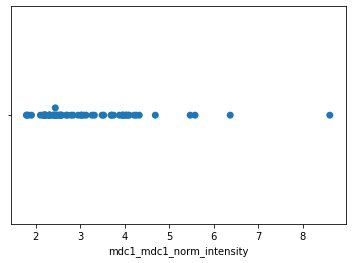

In [9]:
sns.swarmplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],s=7)

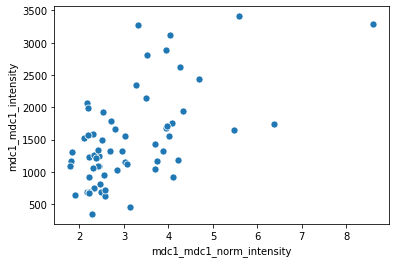

In [10]:
sns.scatterplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],measurement_for_all_fov_df['mdc1_mdc1_intensity'],s=50)

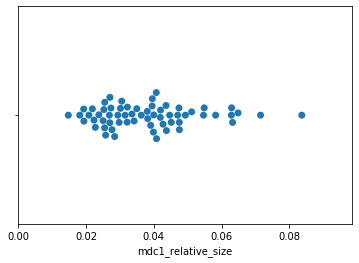

In [11]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_relative_size'],s=7)

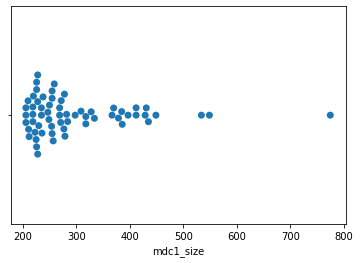

In [12]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_size'],s=7)

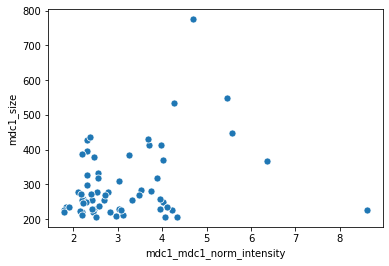

In [13]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_size'],s=50)

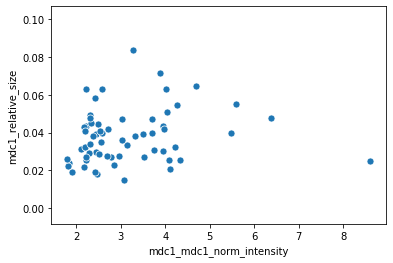

In [14]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_relative_size'],s=50)

In [15]:
measurement_for_all_fov_df_filter=measurement_for_all_fov_df[measurement_for_all_fov_df['nucleus_size']>2000]

In [16]:
len(measurement_for_all_fov_df_filter)

1555

In [17]:
len(measurement_for_all_fov_df)

1851

In [18]:
len(sel_mdc_df)

62

In [19]:
len(sel_mdc_df)/len(measurement_for_all_fov_df_filter)

0.03987138263665595

In [20]:
len(sel_mdc_df)/len(measurement_for_all_fov_df)

0.03349540788762831